In [1]:
import sys
sys.path.append(r"C:\Users\baptiste.menetrier\Desktop\devPy\phd")

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft 
import scipy.io as sio
import scipy.signal as sp

from publication.PublicationFigure import PubFigure
PubFigure()

# Load data 

In [2]:
nperseg = 2**14
noverlap = 2**13
fs = 3276.8
ts = 1 / fs
fmax = 400 # Max frequency emmited 

data = {
    "S5": {"south": {}, "north": {}}, 
    # "S59": {"south": {}, "north": {}},
}
data_root = r"C:\Users\baptiste.menetrier\Desktop\devPy\phd\data\SwellEx96"
name_root = "J1312340.hla"
for event in data.keys():
    for side in data[event].keys():
        fname = f"{name_root}.{side}.mat"
        fpath = os.path.join(data_root, event, fname)
        xdata = sio.loadmat(fpath)["xdata"]
        data[event][side]["sig"] = xdata[:, 0:5]

        # Derive stft
        ff, tt, stft_xdata = sp.stft(
            xdata,
            fs=fs,
            window="hann",
            nperseg=nperseg,
            noverlap=noverlap,
            axis=0
        )
        data[event][side]["stft"] = stft_xdata

nt = data["S5"]["south"]["sig"].shape[0]

# Plot time series 

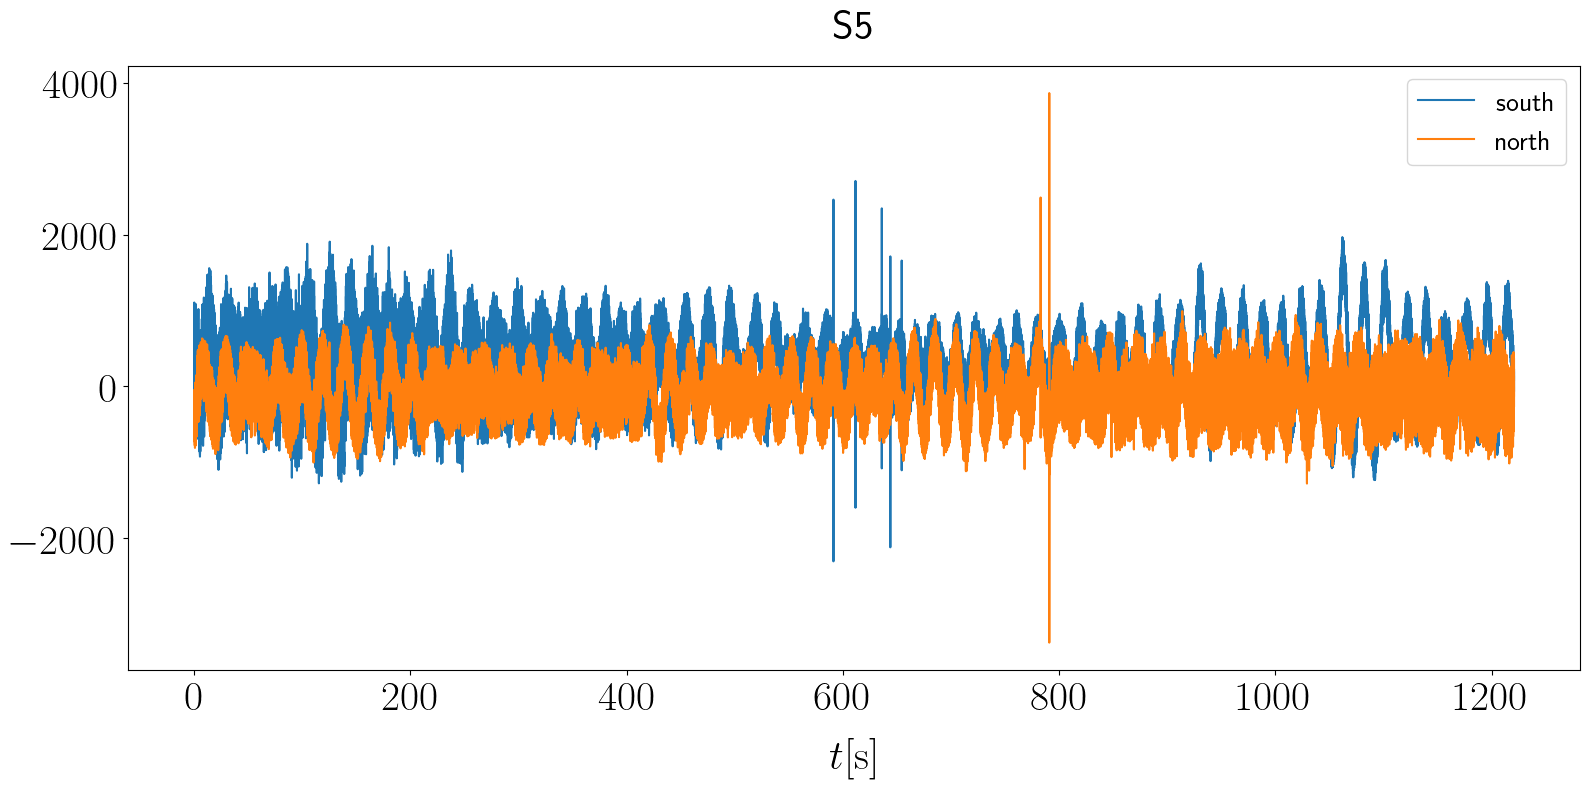

In [3]:
t = np.arange(
    0, nt*ts, ts
)

# Select channel to plot
ch = 0
for event in data.keys():
    plt.figure()
    for side in data[event].keys():
        plt.plot(t, data[event][side]["sig"][:, ch], label=side)
        plt.xlabel(r"$t \textrm{[s]}$")
        plt.title(event)
    plt.legend()


# Plot spectrograms 

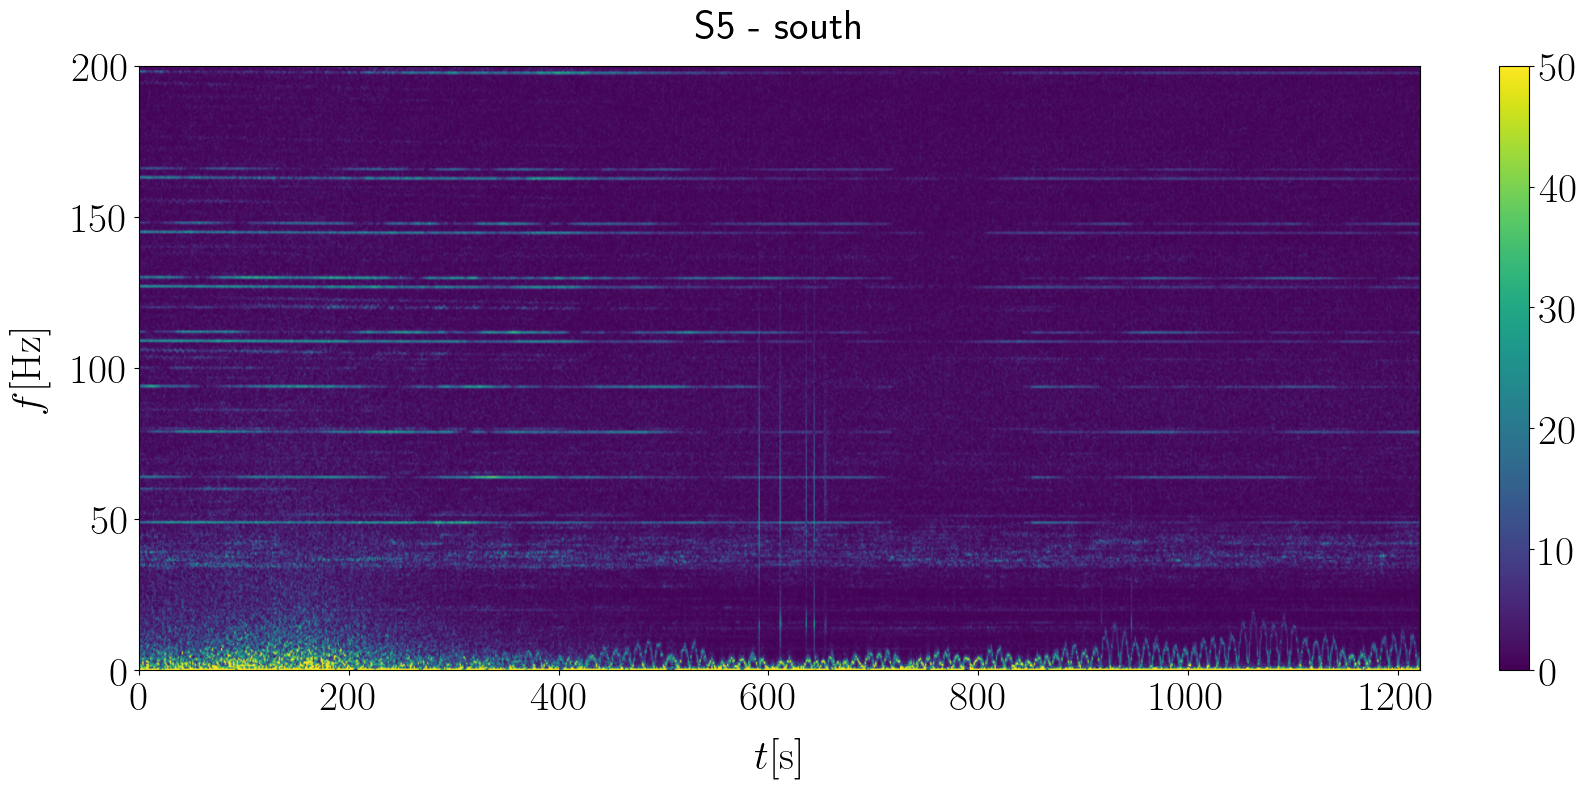

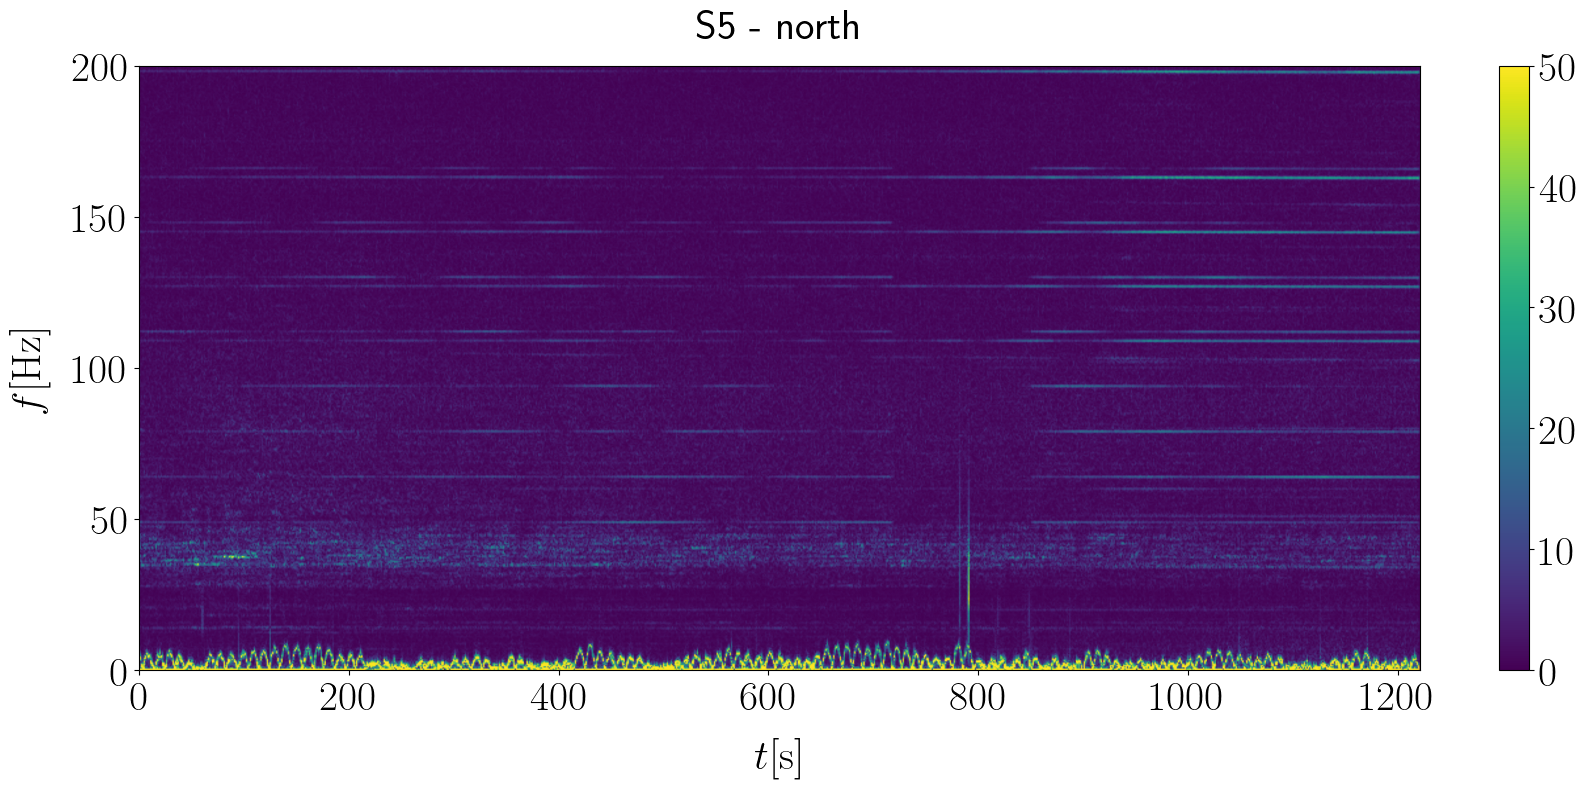

In [14]:
# Plot spectro
for event in data.keys():
    for side in data[event].keys():
        plt.figure()
        plt.ylim([0, fmax/2])
        plt.pcolormesh(
            tt,
            ff,
            np.abs(data[event][side]["stft"][:, ch, :]),
            shading="gouraud", 
            vmin=0, 
            vmax=15,
        )
        plt.xlabel(r"$t \textrm{[s]}$")
        plt.ylabel(r"$f \textrm{[Hz]}$")
        plt.title(f"{event} - {side}")
        plt.colorbar()


In [33]:
# Derive spectrum to identify signal at very low frequency
for event in data.keys():
    for side in data[event].keys():
        # fft
        Sx = fft.fft(data[event][side]["sig"][:, ch])
        data[event][side]["f"] = fft.fftfreq(nt, ts)
        data[event][side]["Sx"] = Sx

        # Psd
        f, Px = sp.welch(data[event][side]["sig"][:, ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
        data[event][side]["f_psd"] = f
        data[event][side]["Px"] = Px

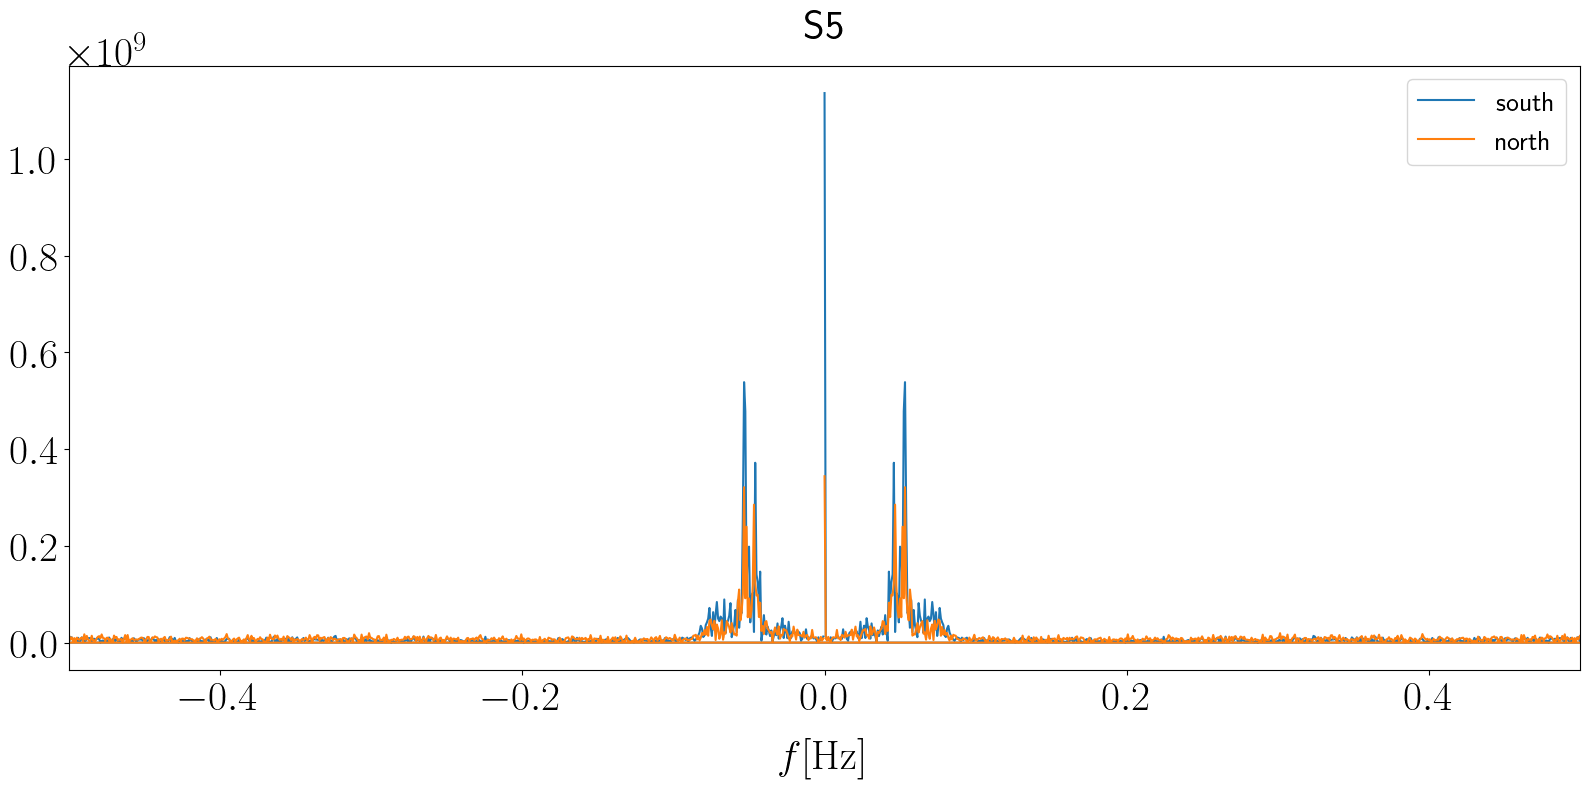

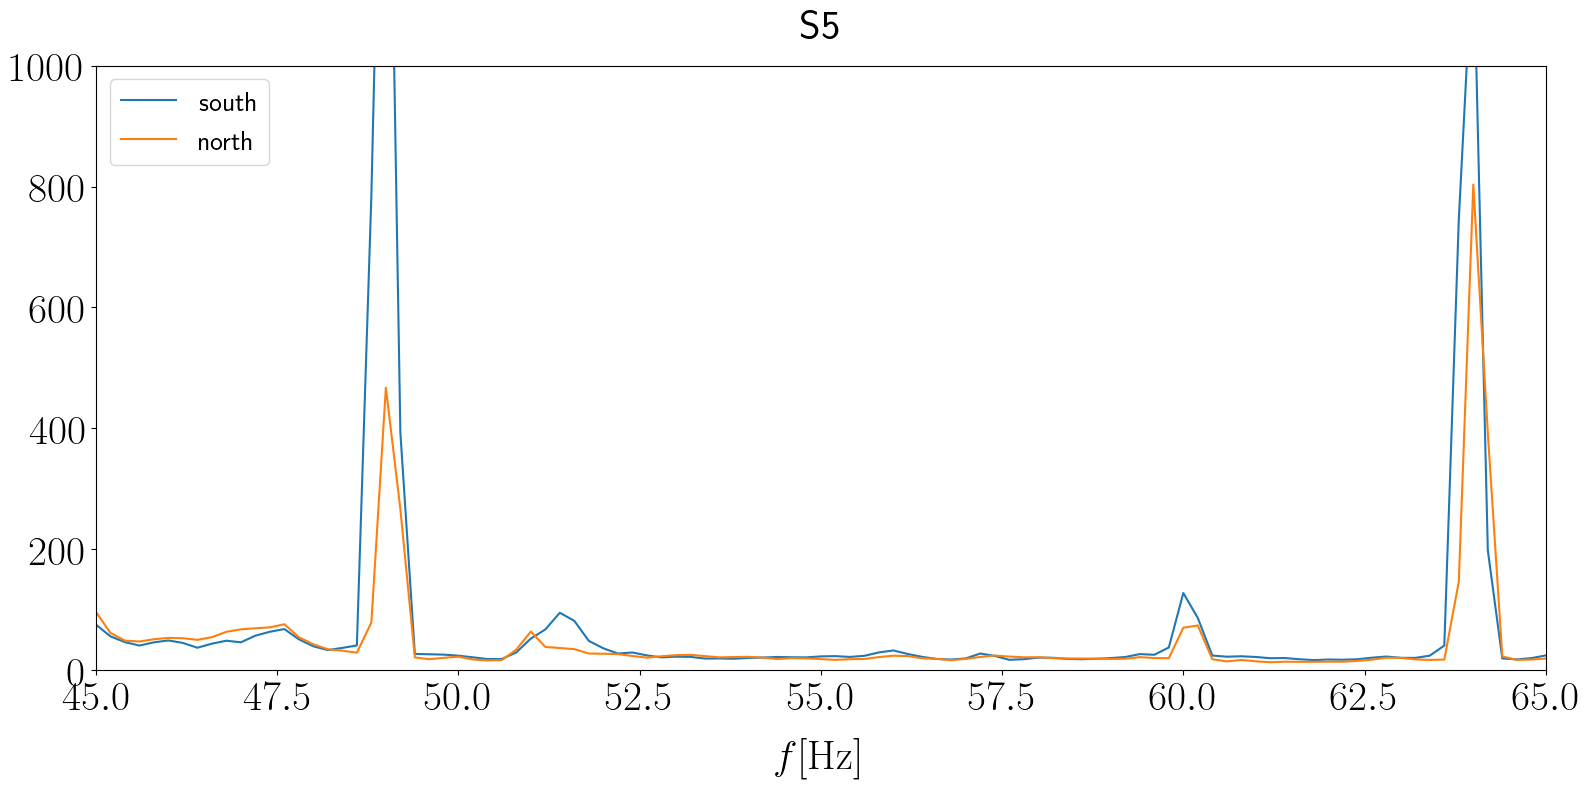

In [34]:
# Plot
for event in data.keys():
    plt.figure()
    for side in data[event].keys():
        plt.plot(data[event][side]["f"], np.abs(data[event][side]["Sx"]), label=side)
        plt.xlabel(r"$f \textrm{[Hz]}$")
        plt.title(event)
        plt.xlim([-0.5, 0.5])
    plt.legend()

    plt.figure()
    plt.xlim([45, 65])
    plt.ylim([0, 1e3])
    for side in data[event].keys():
        plt.plot(data[event][side]["f_psd"], data[event][side]["Px"], label=side)
        plt.xlabel(r"$f \textrm{[Hz]}$")
        plt.title(event)
    plt.legend()

In [ ]:
# Convert to .wav file 
fname = 